In [27]:
import sys
sys.path.append("../")

In [28]:
import numpy as np
import h5py
import pathlib
from matplotlib import pyplot as plt
from scipy import signal
import json
import hampel
import pykalman
from mpl_toolkits import mplot3d
from pose.src import joints

from post_processing.src import hdf5_tools
from post_processing.src import game_tools
from post_processing.src import hampel_filter
from post_processing.src import plotting



%matplotlib inline 
# %matplotlib notebook

In [29]:
data_folder=pathlib.Path("/media/mjsobrep/43CDA61E672B9161/pose")
hdf5_files = hdf5_tools.load_hdf5_files(data_folder)[0]

In [30]:
hdf5_tools.check_data(hdf5_files)

bad data for 060 lower camera openpose
bad data for 060 upper camera mp-hands left hand
bad data for 060 upper camera mp-hands right hand
bad data for 500-3 lower camera openpose
bad data for 500-3 upper camera mp-hands left hand
bad data for 500-3 upper camera mp-hands right hand


In [31]:
subj = '031'
joint=joints.get_openpose_joint('RWrist')

hdf5_tools.print_members(hdf5_files[subj])    

client_count
client_count/data
client_count/time
diagnostics
diagnostics/data
diagnostics/time
diagnostics_toplevel_state
diagnostics_toplevel_state/data
diagnostics_toplevel_state/time
face_state
face_state/data
face_state/time
game_runner
game_runner/actions
game_runner/actions/data
game_runner/actions/time
game_runner/command_opts
game_runner/command_opts/data
game_runner/command_opts/time
game_runner/commands
game_runner/commands/data
game_runner/commands/time
game_runner/def
game_runner/def/data
game_runner/def/time
game_runner/state
game_runner/state/data
game_runner/state/time
game_runner/text
game_runner/text/data
game_runner/text/time
joint_states
joint_states/data
joint_states/time
mobile_base
mobile_base/commands
mobile_base/commands/velocity
mobile_base/commands/velocity/data
mobile_base/commands/velocity/time
mobile_base/sensors
mobile_base/sensors/imu_data
mobile_base/sensors/imu_data/data
mobile_base/sensors/imu_data/time
motor_commands
motor_commands/data
motor_commands

In [32]:
games=game_tools.parse_games(hdf5_files[subj])

added an end to the end


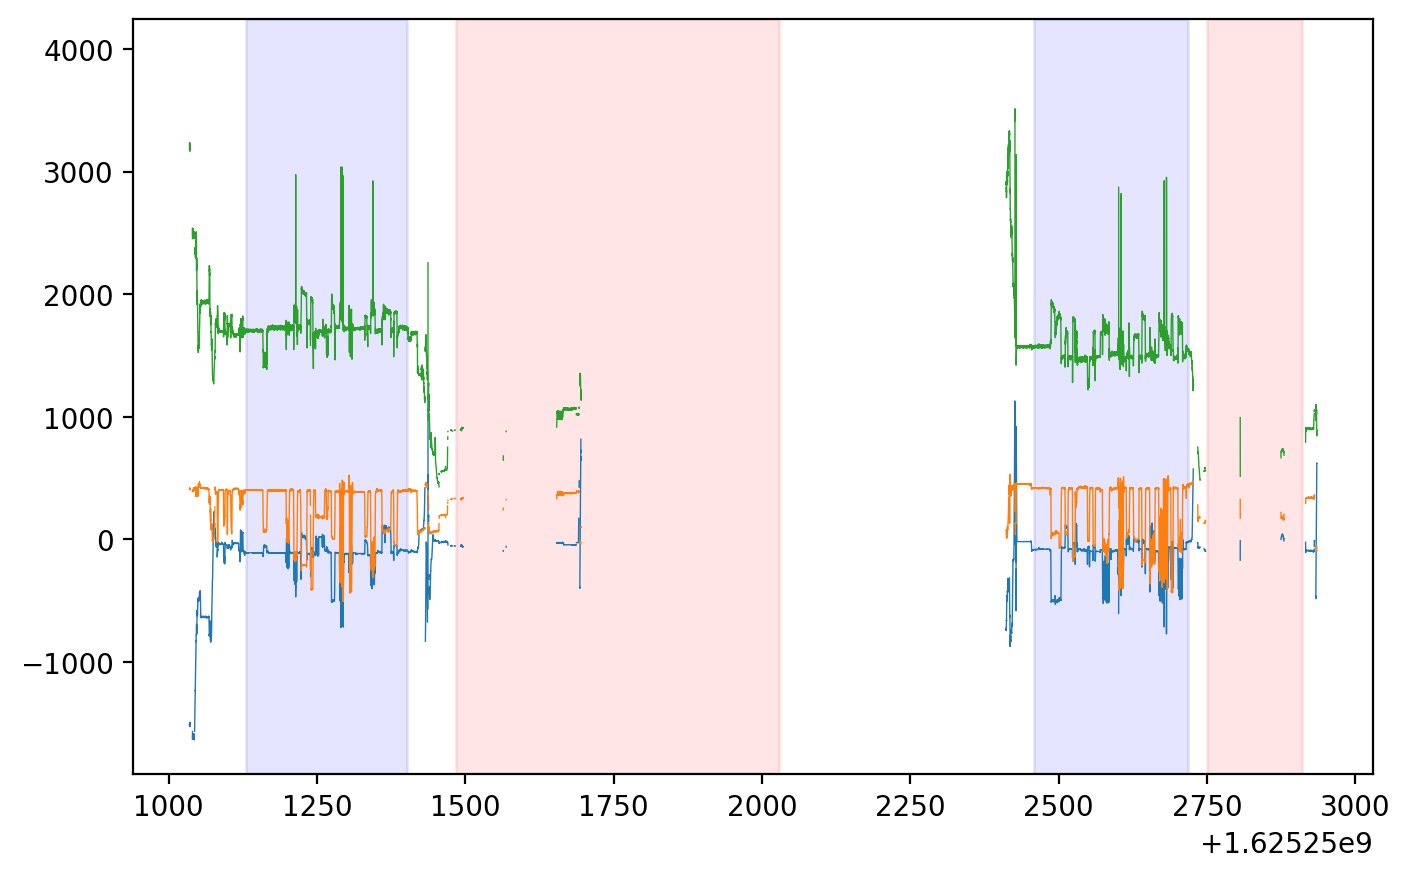

In [33]:
#visualize for wrist
time_name='vid/lower/color/time'
keypoint_name='vid/lower/pose/openpose:25B/keypoints-median5/3d-realsense-raw'
game_idx=2


plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(hdf5_files[subj][time_name][:], hdf5_files[subj][keypoint_name][:,joint,:],linewidth=0.5)

for idx,_ in enumerate(games['type']):
    plt.axvspan(games['start'][idx], games['finish'][idx], alpha=0.1, color=('blue' if games['type'][idx]=='simon_says' else 'red'))


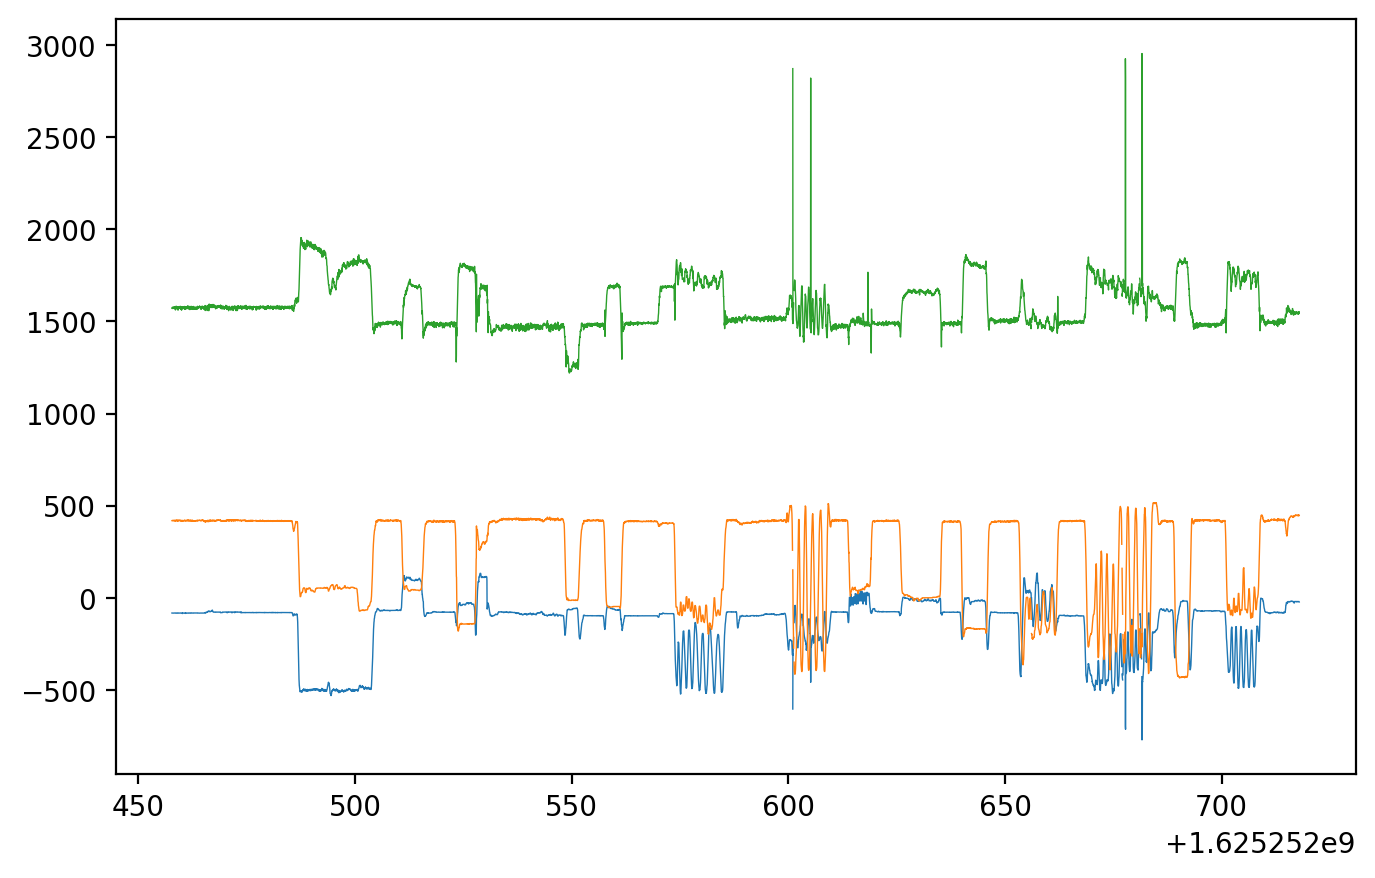

In [34]:
# look a first simon says game:
start_t=games['start'][game_idx]
finish_t=games['finish'][game_idx]
start_idx=np.argmax(hdf5_files[subj][time_name][:]>start_t)
finish_idx=np.argmax(hdf5_files[subj][time_name][:]>finish_t)

game_time=hdf5_files[subj][time_name][start_idx:finish_idx]
game_pose=hdf5_files[subj][keypoint_name][start_idx:finish_idx,joint,:]

plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
# signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1])
plt.plot(game_time, game_pose, linewidth=.5)

In [35]:
bad_vals = np.unique(np.concatenate([hampel_filter.hampel_filter_v(game_pose[:,axis],50,5) for axis in range(3)], axis=0))

In [36]:
bad_vals_t = np.unique(np.concatenate([hampel_filter.hampel_filter_v(game_pose[:,axis],50,5) for axis in range(3)], axis=0))
game_pose_t=game_pose.copy()
game_pose_t[bad_vals_t,:]=np.nan

In [37]:
len(bad_vals)/len(game_pose)

0.04166040006015942

In [38]:
game_pose[bad_vals,:]=np.nan

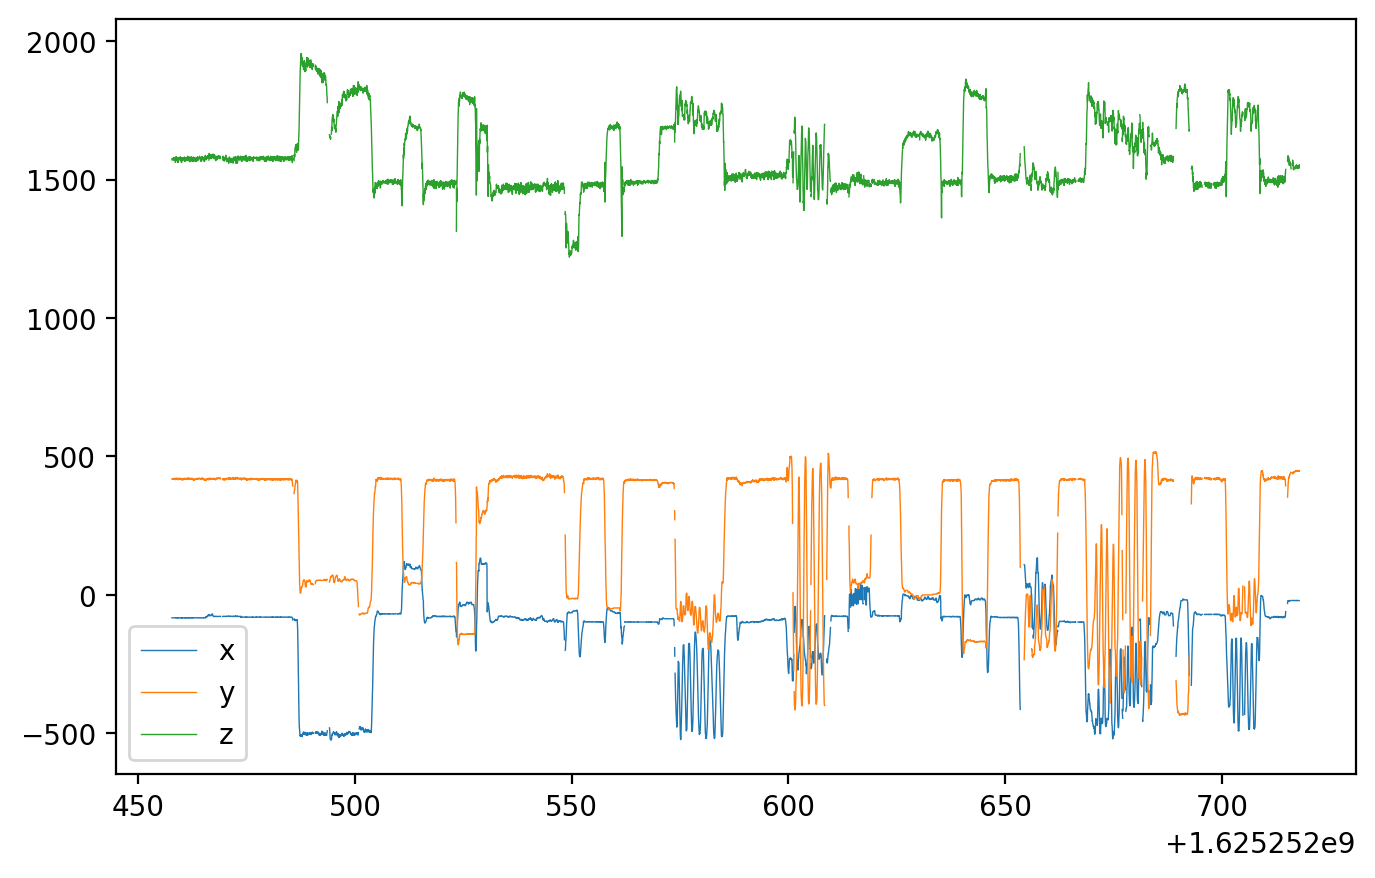

In [39]:
plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(game_time, game_pose, linewidth=.5)
# plt.plot(game_time[bad_vals],np.ones(len(bad_vals))*1000,'.',markersize=.1)
plt.legend(['x','y','z'])

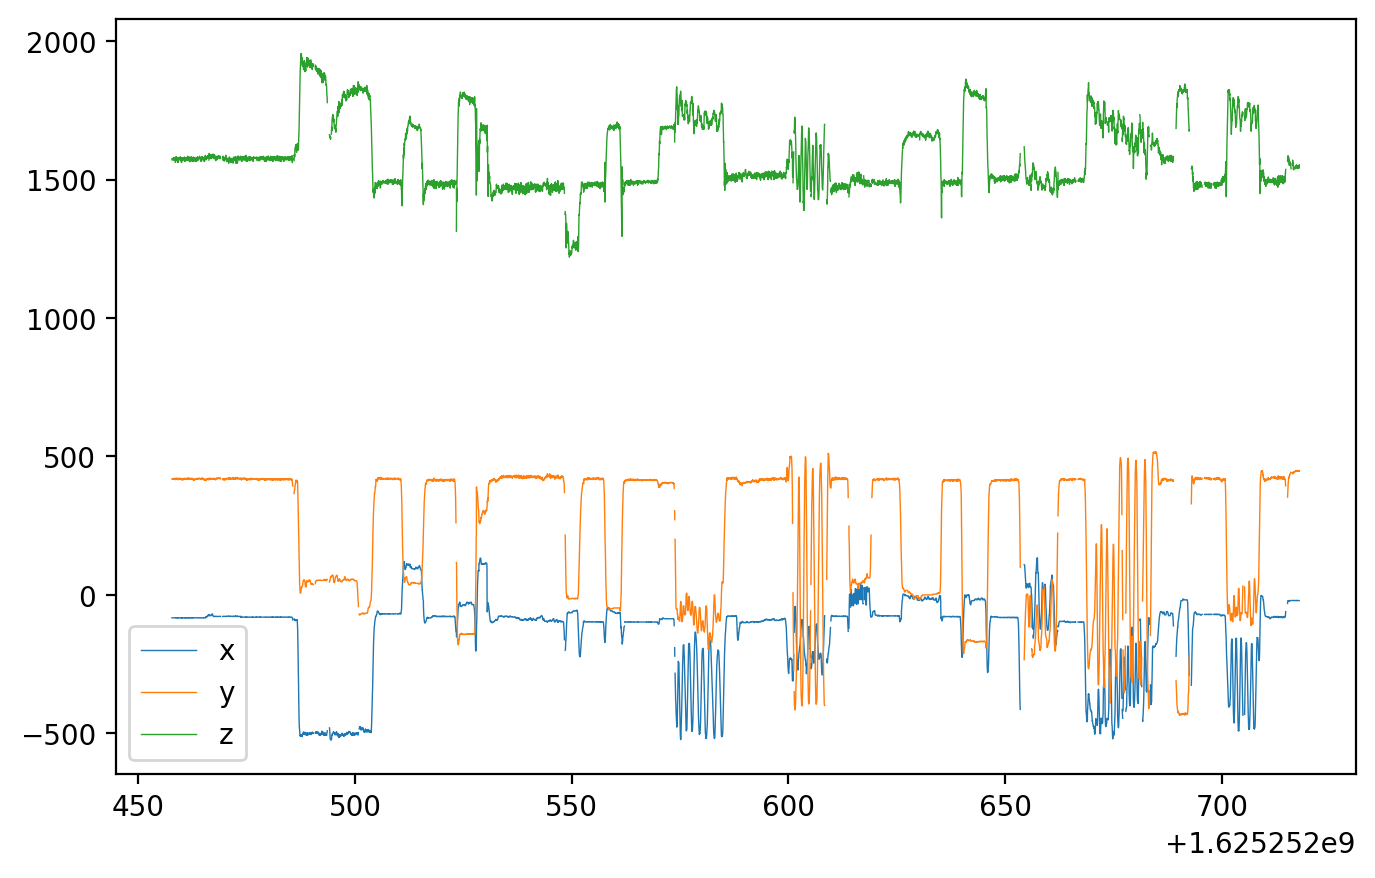

In [40]:
plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(game_time, game_pose_t, linewidth=.5)
# plt.plot(game_time[bad_vals],np.ones(len(bad_vals))*1000,'.',markersize=.1)
plt.legend(['x','y','z'])

In [18]:
# Now kalman smoother to 1) smooth and 2) get velocity and acceleration
# Measurement function (we measure x, y, and z positions)
H = np.array([[1,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0],
             ])

# P0 = np.array([[0,0,0,0,0,0,0,0,0], # initially could be anywhere, let's assume that they are in front of the camera and about 1 meter away
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0], # assume no velocity or accel
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0],
#                [0,0,0,0,0,0,0,0,0]
#               ])
# Transistion covariance - assume velocity only changes due to acceleration and position only changes due to velocity
Q = [np.array([[0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,0,1]
              ])*((100000*dt)**2) for dt in np.diff(game_time)]
# where to get acceleration: 
# - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4689593/#:~:text=Most%20movements%20were%20about%200.2,5%20and%2030%20cm%2Fs.
# - 5000 mm/s^2 : https://doi.org/10.5281/zenodo.1098112
# - 20,000 mm/s^2 (fast, upward swing) 7k mm/s^2 (normal)  : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3134452/
# So then what is the standard deviation of motion?

# Need to focus on jerk, that defines the process progression of acceleration. From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3134452/
# FAST 2-3 SD?:
# peak accel = 20 m/s^2
# Time to peak accel = .1 s
# Jerk = 20 m/s^2 / .1 s = 200 m/s^3 = 200,000 mm/s^3
# NORMAL:
# peak accel = 7 m/s^2
# Time to peak accel = .125 s
# Jerk = 7 m/s^2 / .125 s = 56 m/s^3 = 56000 mm/s^3

# FROM https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5350272/
# Normal Jerk for reaching motion ~ 10,000 cm/s^3 = 100,000 mm/s^3

# Observation covariance
R=[[30**2,     0,     0],
   [    0, 30**2,     0],
   [    0,     0, 80**2]]
# RealSense is +/- 2% (https://www.intelrealsense.com/wp-content/uploads/2022/03/Intel-RealSense-D400-Series-Datasheet-March-2022.pdf)
# so that is the z uncertainty. Because we use z for getting x y position from pixels, this affects x and y as well. If we think 
# about what just the pixel accuracy leads to, expect openpose to be +/- 15 pixels? at 1 meter away, d415 color horiz 69 deg, vert 42 deg
# so with horiz resolution 1920 at
#    - 1 meter, 1.374 meters across frame -> .72 mm/pixel so like +/- 10mm for openpose
#    - 2 meter, 2.75 meters across frame -> 1.43 mm / pixel so like +/- 21.5 mm
#    - call it +/- 15 mm?
#    - 1.375*z/1920*15
# and +/- 20 mm for realsense at 1 meter, +/- 40 mm at 2 m. 
# Because these are coupled and I don't know how to handle the coupling, I am just going to double the sd... 
# We could use the confidence of the pose detection as well, not sure what confidence actually translates to though

# State transistion matrix
Fs = [np.array([[1, 0, 0, dt,  0,  0, 1/2*(dt**2),           0,           0],
                [0, 1, 0,  0, dt,  0,           0, 1/2*(dt**2),           0],
                [0, 0, 1,  0,  0, dt,           0,           0, 1/2*(dt**2)],
                [0, 0, 0,  1,  0,  0,          dt,           0,           0],
                [0, 0, 0,  0,  1,  0,           0,          dt,           0],
                [0, 0, 0,  0,  0,  1,           0,           0,          dt],
                [0, 0, 0,  0,  0,  0,           1,           0,           0],
                [0, 0, 0,  0,  0,  0,           0,           1,           0],
                [0, 0, 0,  0,  0,  0,           0,           0,           1]
               ]) for dt in np.diff(game_time)]

kf = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
#                             initial_state_mean=x0, #initial_state_covariance=P0,
                             observation_covariance=R, transition_covariance=Q)

In [19]:
np.sin(45)

0.8509035245341184

In [20]:
game_pose_masked=np.ma.array(game_pose)
game_pose_masked[np.isnan(game_pose_masked)]=np.ma.masked
# Initial vals
init_meds = np.ma.median(game_pose_masked[:20],axis=0)
kf.initial_state_mean=np.array([init_meds[0],init_meds[1],init_meds[2],0,0,0,0,0,0]) 
xs, _ = kf.smooth(game_pose_masked)

In [21]:
kf.em(game_pose_masked, em_vars=['observation_covariance','transition_covariance'])
xs2, _ = kf.smooth(game_pose_masked)

/home/mjsobrep/.local/lib/python3.8/site-packages/pykalman/standard.py:1397: UserWarning: transition_covariance has 3 dimensions now; after fitting, it will have dimension 2
  warnings.warn(warn_str)


In [22]:
kf.observation_covariance-R

array([[-8.90326691e+02, -3.00362250e-01, -3.87994926e+00],
       [-3.00362241e-01, -8.83625887e+02,  1.62073401e+01],
       [-3.87994926e+00,  1.62073401e+01, -6.30822771e+03]])

In [23]:
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=150)
print(np.round(kf.transition_covariance-np.median(Q,axis=0)))

[[       0.        0.       -0.        0.       -0.        0.       -0.       -0.        0.]
 [      -0.       -0.       -0.        0.        0.        0.        0.       -0.        0.]
 [       0.        0.        0.       -0.       -0.       -0.       -0.       -0.        0.]
 [      -0.       -0.        0.       -0.        0.       -0.        0.       -0.        0.]
 [       0.       -0.        0.       -0.       -0.       -0.        0.        0.        0.]
 [      -0.       -0.        0.        0.        0.        0.       -0.        0.       -0.]
 [      -0.       -0.        0.        0.        0.       -0. -7946744.   274589.   225626.]
 [       0.        0.        0.       -0.        0.       -0.   274589. -7617753.   302554.]
 [      -0.       -0.       -0.        0.        0.       -0.   225626.   302554. -8526424.]]


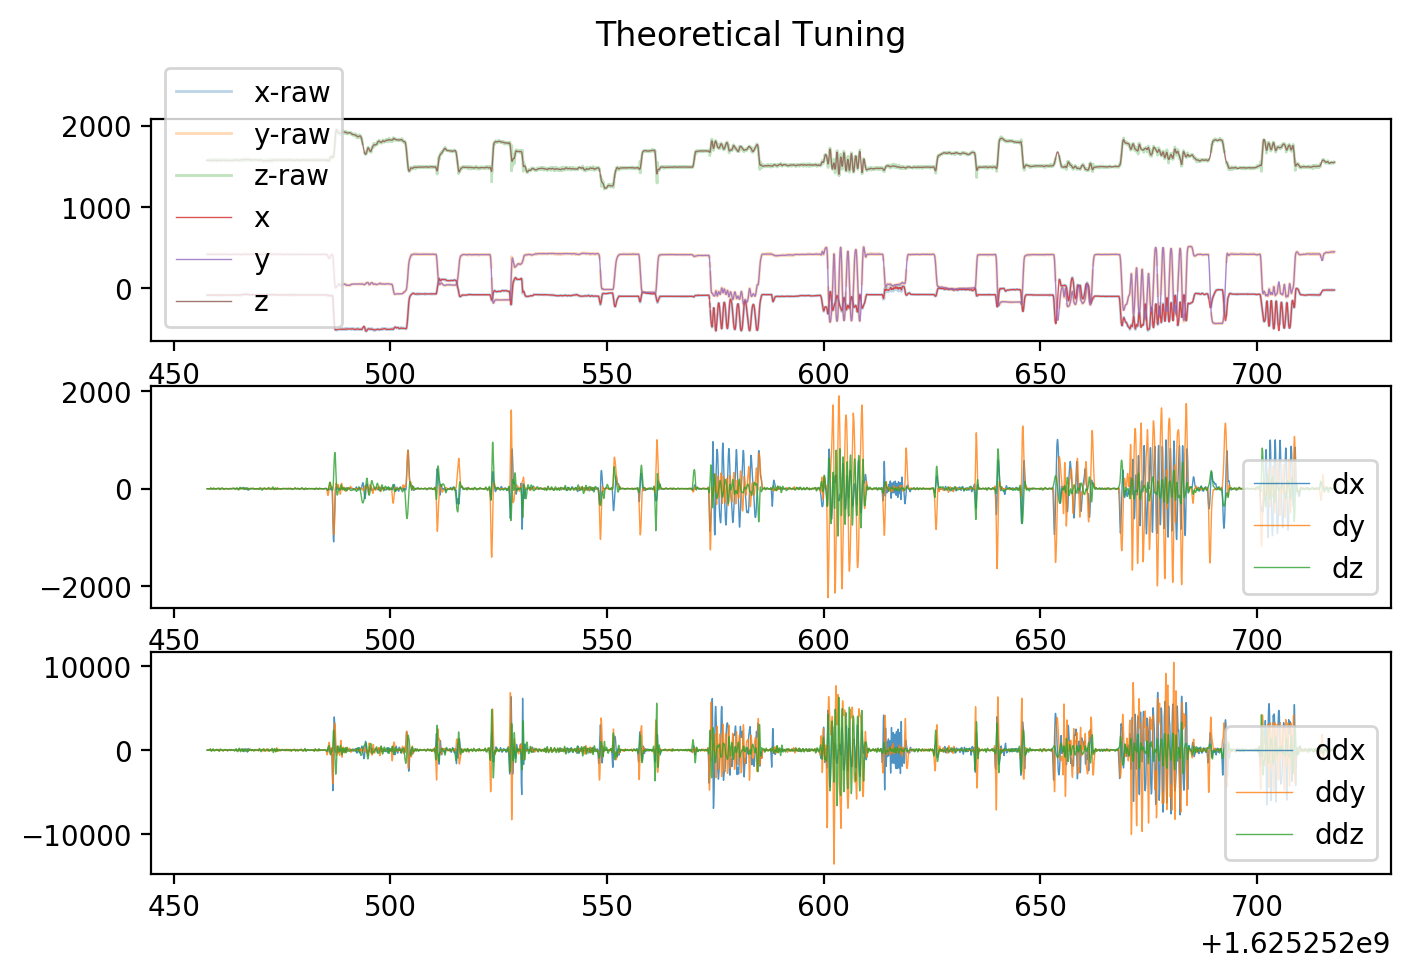

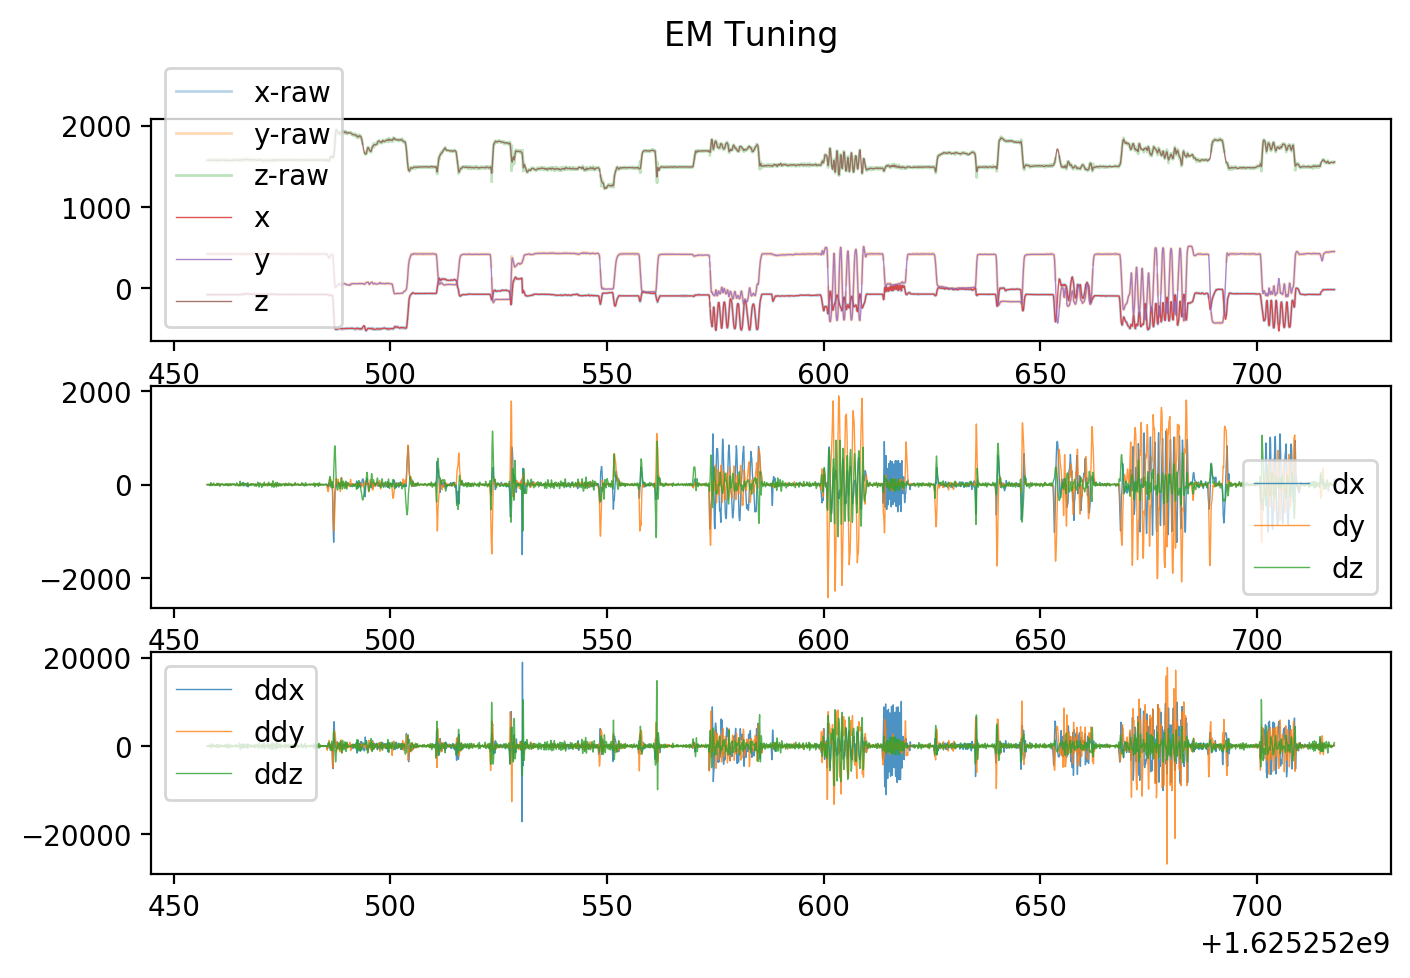

In [24]:
plotting.plot_model_results(game_time, game_pose_masked, xs, title='Theoretical Tuning')
plotting.plot_model_results(game_time, game_pose_masked, xs2, title='EM Tuning')

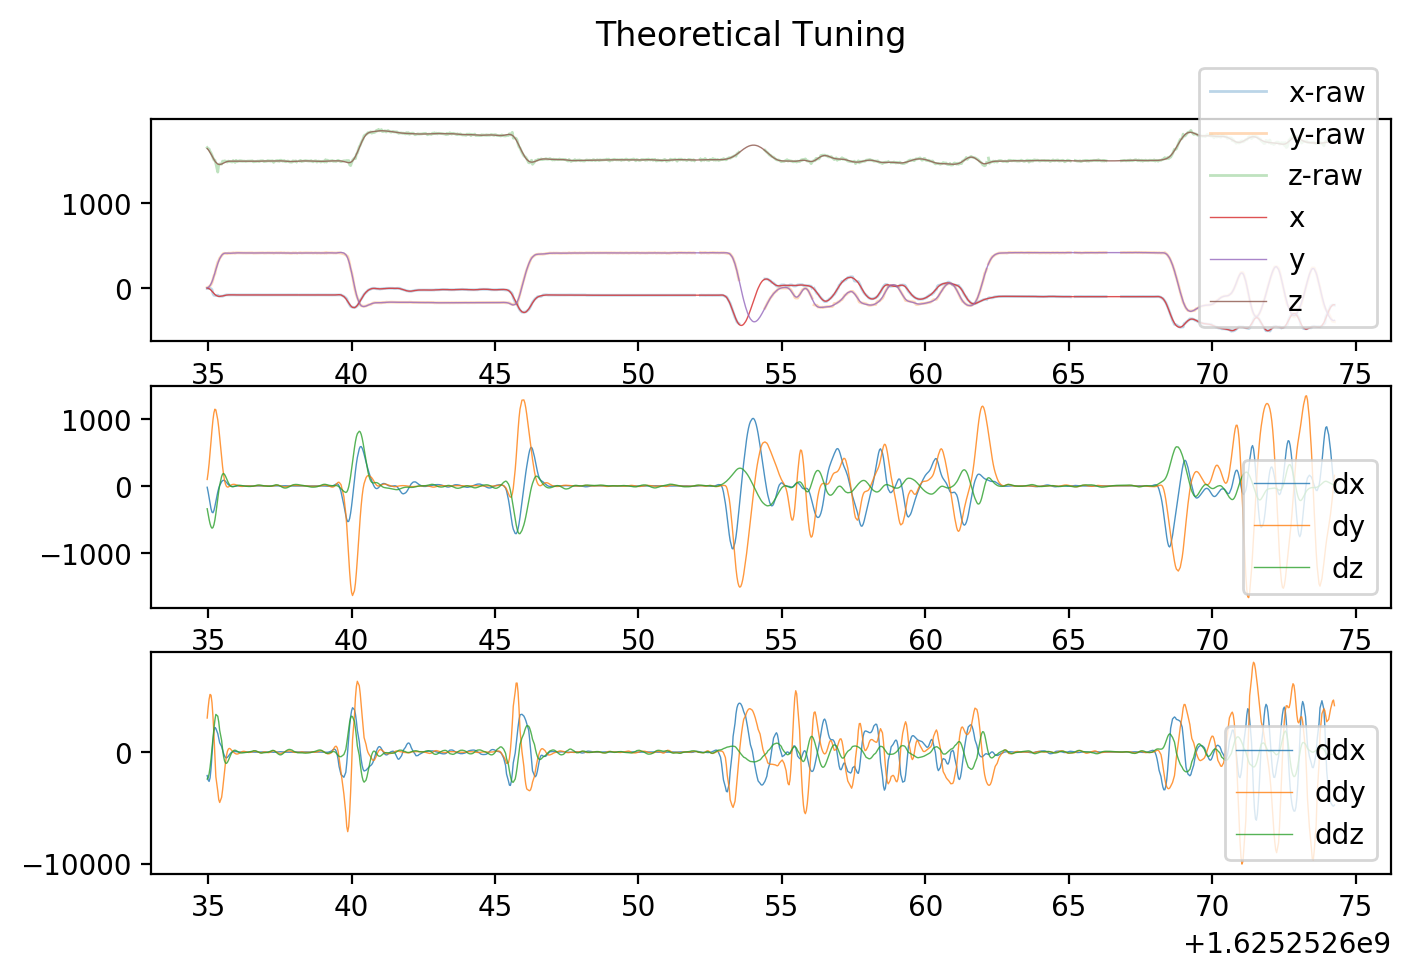

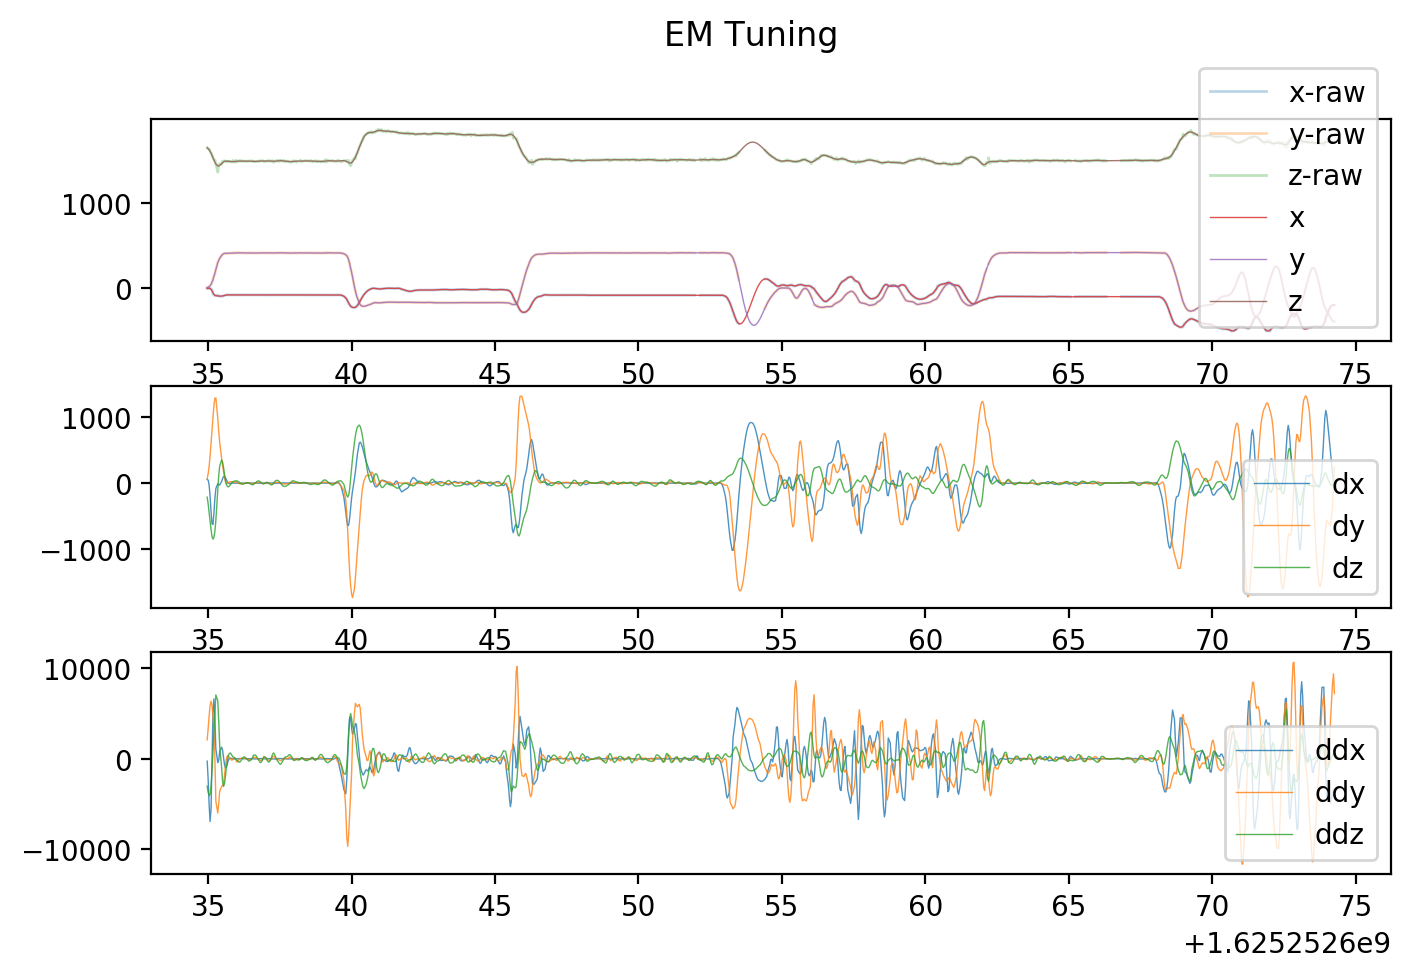

In [25]:
st=4500
num_idx=1000
plotting.plot_model_results(game_time,game_pose_masked, xs,st, num_idx, title="Theoretical Tuning")
plotting.plot_model_results(game_time,game_pose_masked, xs2, st, num_idx, title="EM Tuning")

Huh, my values actually look better than the em fit values

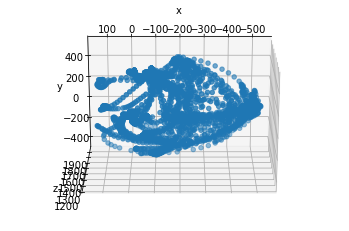

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(xs[:,0],xs[:,1],xs[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(-70, 90)